## Assignment 5.2
### Exercises 5 - 1, 5 - 2, and 6 - 1

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
# Imports
import brfss
import thinkstats2
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from empiricaldist import Cdf
from statsmodels.distributions.empirical_distribution import ECDF

## Exercise 5 - 1

*In the BRFSS, the distribution of heights is roughly normal with parameters $\mu$ = 178cm and $\sigma$ = 7.7 cm for men, and $\mu$ = 163 cm and $\sigma$ = 7.3cm for women*

*In order to join Blue Man Group, you have to be male and between 5'10" and 6'1" tall.*

*What percentage of the US male population is in this range?*

In [2]:
df = brfss.ReadBrfss()
df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


In [8]:
# Get the normal distribution with parameters: mean = 178 and Standard Deviation of 7.7
mu = 178
sigma = 7.7

sample = stats.norm(loc = mu, scale = sigma)
sample

In [9]:
# Convert inches to cm
min_height = ((5 * 12) + 10) * 2.54
max_height = ((6 * 12) + 1) * 2.54

# Percentage of men under 5' 10"
men_min_height = sample.cdf(min_height)

# Percentage of men under 6' 1"
men_max_height = sample.cdf(max_height)

# Percentage of men between 5' 10" and 6' 1"
men_within_range = men_max_height - men_min_height

print(f"Men at 5' 10\": {round(men_min_height, 2) * 100}%")
print(f"Men at 6' 1\": {round(men_max_height, 2) * 100}%")
print(f"Men within range: {round(men_within_range, 2) * 100}%")

Men at 5' 10": 49.0%
Men at 6' 1": 83.0%
Men within range: 34.0%


Within the US population for men approximately 34% of them would qualify to be in the Blue Man Group

## Exercise 5 - 2

*To get a feel for the Pareto distribution, lets see how different the world would be if the distrbution of human
height were Pareto. With the parameters $x_{m}$ = 1 m and $\alpha$ = 1.7, we get a distribution with a reasonable 
minimum, 1 m, and median, 1.5 m*

*Plot this distribution*

In [10]:
alpha = 1.7
xmin = 1

dist = stats.pareto(b = alpha, scale = xmin)
dist

*What is the mean human height in Pareto world?*

In [12]:
mean_height = dist.mean()
print(f"Mean height (m): {mean_height}")
print(f"Mean height (ft): {mean_height * 3.281}")

Mean height (m): 2.428571428571429
Mean height (ft): 7.968142857142858


The mean height in a Pareto world is 2.4 meters or about 8 feet tall

*What fraction of the population is shorter than the mean?*

In [7]:
percent_shorter = dist.cdf(mean_height)
percent_shorter

0.778739697565288

About 77% of the people are shorter than 2.4 meters

*If there are 7 billion people in Pareto world, now many do we expect to be taller than 1 km?*

In [8]:
amt_shorter = dist.cdf(1000)
amt_taller = 1 - amt_shorter

total_pop_taller = amt_taller * 7000000000
total_pop_taller

55602.976430479954

About 55,603 people wouldbe taller than 1 km

*How tall do we expect the tallest person to be?*

In [15]:
tallest_person = dist.ppf( 1 - (1 / 7000000000))
print(f"Tallest person (km) : {tallest_person}")
print(f"Tallest person (ft) : {tallest_person * 3281}")

Tallest person (km) : 618349.6106759505
Tallest person (ft) : 2028805072.6277938
1.0525455861201714


The tallest person would be 618,350 km or 2,028,805,072 ft

## Exercise 6 - 1

*The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.*

*The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm.*

*The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income "Under \\$ 5000."  The highest range includes respondents who made "\\$ 250,000 or more."*

*To estimate the mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range.*

In [5]:
import hinc
hinc_df = hinc.ReadData()
hinc_df.head()

,income,freq,cumsum,ps
0,4999.0,4204,4204,0.034330
1,9999.0,4729,8933,0.072947
2,14999.0,6982,15915,0.129963
3,19999.0,7157,23072,0.188407
4,24999.0,7131,30203,0.246640


In [6]:
def InterpolateSample(df, log_upper = 6.0):
    '''
    Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    args:
        df (DataFrame): Dataframe with columns income and freq
        log_upper (float): log10 of the assumed upper bound for the highest range

    returns: 
        log_sample (array): NumPy array of log10 household income
    '''
    
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    
    return log_sample

Text(0, 0.5, 'CDF')

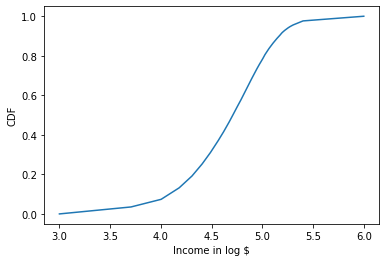

In [43]:
# Upper_log = 6 => represents the assumption that the largest income among the respondents is $1,000,000
log_sample = InterpolateSample(hinc_df, log_upper = 6.0)
log_sample_cdf = Cdf.from_seq(log_sample)
log_sample_cdf.plot()
plt.xlabel('Income in log $')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

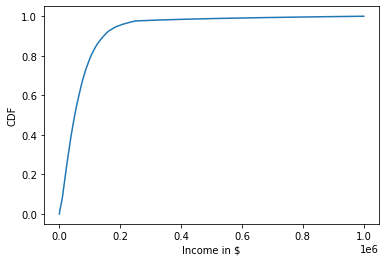

In [44]:
sample = np.power(10, log_sample)
sample_cdf = Cdf.from_seq(sample)
sample_cdf.plot()
plt.xlabel('Income in $')
plt.ylabel('CDF')

*Compute the median, mean, skewness and Pearson's skewness of the resulting sample.*

In [61]:
# Mean income of the sample
income_mean = sample.mean()
print(f'The mean income is ${income_mean}')

The mean income is $74278.7075311872


In [60]:
# Median income of the sample
income_median = np.median(sample)
print(f'The median income is ${income_median}')

The median income is $51226.93306562372


In [59]:
# Skewness of the sample
income_skewness = stats.skew(sample)
print(f'The skewness is {income_skewness} indicating it is skewed right')

The skewness is 4.949920244429584 indicating it is skewed right


In [39]:
# standard Deviation of the sample
income_var = np.var(sample)
income_stdDev = np.sqrt(income_var)
income_stdDev

93946.92996347835

In [58]:
# Pearson's skewness of the sample
income_pearson = 3 * (income_mean - income_median) / income_stdDev
print(f"The Pearson's skewness is {income_pearson}")

The Pearson's skewness is 0.7361105192428792


*What fraction of households reports a taxable income below the mean?*

In [57]:
# Calculate the Empirical Distribution of the sample
ecdf = ECDF(sample)
print(f'Probability that income less than the mean): {ecdf(income_mean)}')

Probability that income less than the mean): 0.6600058795668718


*How do the results depend on the assumed upper bound?*

Without knowing exactly what the highest income is we can only guess so the results just depends on how well
we guess.